This file is used to decide the distance threshold for same entity retrieval.

In [2]:
import yaml
import sys
sys.path.append('..')
from AutoKGC.tools.db_manager import DBManager
with open('../config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
config['chromadb']['persist_directory'] = '../data/chroma'

In [4]:
db_manager = DBManager(**config['neo4jdb'], **config['chromadb'])

In [6]:
generations = db_manager.vector_db.get_from_specific_source('generated')['metadatas']
generations_docs = db_manager.vector_db.get_from_specific_source('generated')['documents']
for i in range(len(generations)):
    generations[i]['documents']=generations_docs[i]

In [7]:
# improt the lib so that i can create dictory with default value
from collections import defaultdict
name_description_map = defaultdict(list)
for generation in generations:
    is_general = generation['general']
    name = generation['name']
    description = generation['documents']
    name_description_map[name].append(description)

In [14]:
ef = db_manager.vector_db.collection._embedding_function

In [73]:
import torch
from tqdm import tqdm
same_entity_scores = []
for key in tqdm(name_description_map.keys()):
    same_entities = name_description_map[key]
    num_same_entities = len(same_entities)
    if num_same_entities < 2:
        continue
    same_entities_emb = [db_manager.vector_db.collection._embedding_function(entity) for entity in same_entities]
    same_entities_emb_torch_list = []
    for emb in same_entities_emb:
        same_entities_emb_torch_list.append(torch.tensor(emb).mean(dim=0))
    same_entities_emb_torch = torch.stack(same_entities_emb_torch_list, dim=0)
    # TODO: calculate the l2 distance between same entities.
    for i in range(num_same_entities):
        for j in range(i+1, num_same_entities):
            same_entity_scores.append(torch.dist(same_entities_emb_torch[i], same_entities_emb_torch[j], p=2).item())

100%|██████████| 333/333 [03:56<00:00,  1.41it/s]


total number of same entity pairs: 138


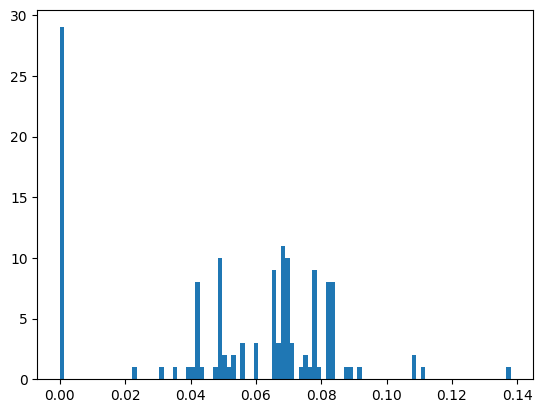

In [78]:
import matplotlib.pyplot as plt
print(f"total number of same entity pairs: {len(same_entity_scores)}")
res = plt.hist(same_entity_scores, bins=100)

In [91]:
import torch
from tqdm import tqdm
import random
diff_entity_scores = []
name_keys = list(name_description_map.keys())
# random sample 100 pairs of (key, key)
name_key_pairs = random.sample([(name_keys[i], name_keys[j]) for i in range(len(name_keys)) for j in range(i+1, len(name_keys))], 100)
diff_entity_scores = []
for name_key_pair in tqdm(name_key_pairs):
    name1, name2 = name_key_pair
    entity1 = name_description_map[name1][0]
    entity2 = name_description_map[name2][0]
    entity1_emb = db_manager.vector_db.collection._embedding_function(entity1)
    entity2_emb = db_manager.vector_db.collection._embedding_function(entity2)
    entity1_emb_torch = torch.mean(torch.tensor(entity1_emb), dim=0)
    entity2_emb_torch = torch.mean(torch.tensor(entity2_emb), dim=0)
    diff_entity_scores.append(torch.dist(entity1_emb_torch, entity2_emb_torch, p=2).item())

100%|██████████| 100/100 [21:50<00:00, 13.11s/it]


total number of different entity pairs: 100


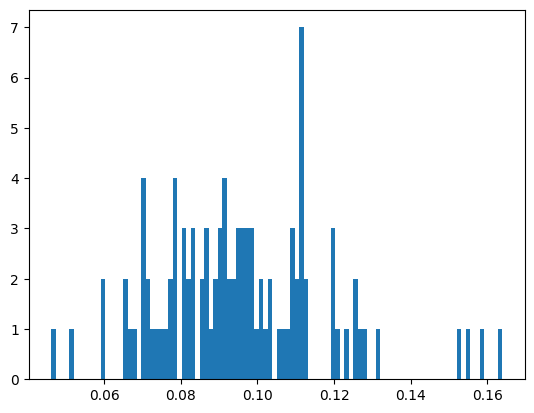

In [94]:
res = plt.hist(diff_entity_scores, bins=100)
print(f"total number of different entity pairs: {len(diff_entity_scores)}")